# DAV 6150 Module 2 Assignment - Cross Validation

## 1. Introduction
According to the data set information, the Cycle Power Plant Data Set includes five columns. Four columns are hourly average ambient variables, which are Temperature (T), Ambient Pressure (AP), Relative Humidity (RH) and Exhaust Vacuum (V). The other column is the net hourly electrical energy output (EP) of the plant. **In this assignment, the four ambient variables will be taken as candidate explanatory variables to create a linear regression model for predicting the response variable EP.** <br>
<br>
The planned steps can be summarized as following:
- a. Import the data set and apply exploratory data analysis to know details on each variable, including basic descriptive statistic values and data distribution pattern. Also, explore the correlation of EP and other four variables to determine the variables which can be recruited for the prediction model. 
- b. Label the explanatory variables and response variable. 
- c. Select combinations of explanatory variables for fitting different linear regression models.
- d. Divide the data into K=10 groups for cross-validation.
- e. Evaluate the accuracy of models.

Now, let's import the data first.

In [1]:
# import pandas libraries for dataframe loading
import pandas as pd
# read data into dataframe
df=pd.read_csv(r'https://raw.githubusercontent.com/chenkecoco1/DAV-6150/main/M2_Data.csv')
# check loading
df.head()

,T,V,AP,RH,EP
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


As the short form of column names are not intuitive, they could be substitute by real names.

In [2]:
# change column names based on data set information, keep 'EP'.
df.columns = ['Temperature','Exhaust Vacuum','Ambient Pressure','Relative Humidity','EP']
df.head()

,Temperature,Exhaust Vacuum,Ambient Pressure,Relative Humidity,EP
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


## 2. Exploratory Data Analysis

In [3]:
# check line numbers and null values of data set
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Temperature        9568 non-null   float64
 1   Exhaust Vacuum     9568 non-null   float64
 2   Ambient Pressure   9568 non-null   float64
 3   Relative Humidity  9568 non-null   float64
 4   EP                 9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB


There are no null values in the data set. Total 9568 rows of record with float type of data, which means all numerical.

In [4]:
# basic descriptive values of the dataset
df.describe()

,Temperature,Exhaust Vacuum,Ambient Pressure,Relative Humidity,EP
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452473,12.707893,5.938784,14.600269,17.066995
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


For viewing the data in each column directly, the histograms and box plots will be created as below.

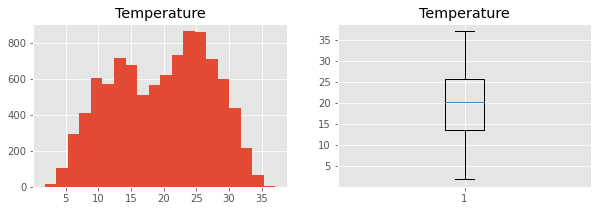

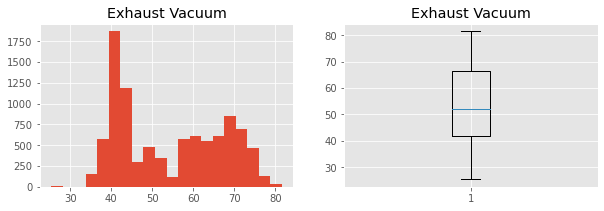

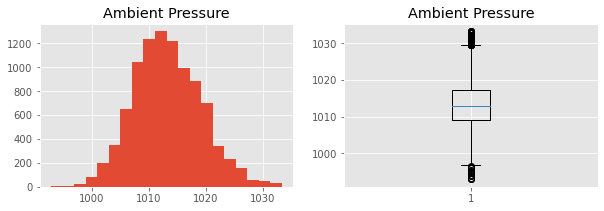

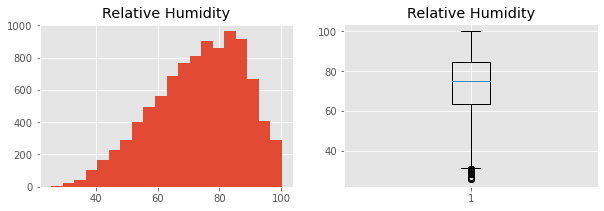

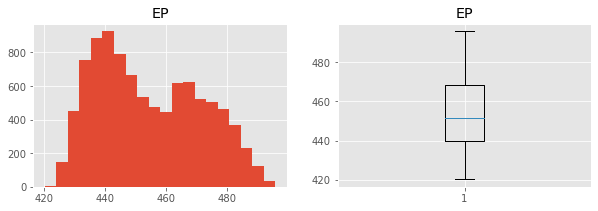

In [5]:
# import pyplot for graph creating
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# for each column, create a histogram and boxplot side by side
for i in range(0,5):
    figure, axis = plt.subplots(1, 2,figsize=(10,3))
    a=df.iloc[:,i]
    axis[0].hist(a, bins=20)
    axis[0].set_title(df.columns[i])
    axis[1].boxplot(a)
    axis[1].set_title(df.columns[i])
    plt.show()

For the candidate explanatory variables, Temperature and Exhaust Vacuum show bimodal distribution. For Temperature, the two high points appear at around 12 and 25 (°C). Two high points of Exhaust Vacuum are at around 40 and 70 (cm Hg). Both variables have no outliers. The two bimodal distribution patterns may be an indication that the two variables have some relation internally. Ambient pressure is nearly normal distributed with peak at around 1012 (milibar). Both tails of the distribution have many outliers. The Relative humidity shows left skewed distribution pattern. Extreme small values could be found based on the box plot. The response variable EP also shows bimodal distribution, peak points at 440 and 470 (MW). It raises the guessing that Temperature and Exhaust Vacuum may have a stronger relation with EP.

For picking out the variables which may contribute the prediction model, the correlation of the four candidate explanatory variables and the response variable matrix will be created below. 

                   Temperature  Exhaust Vacuum  Ambient Pressure  \
Temperature           1.000000        0.844107         -0.507549   
Exhaust Vacuum        0.844107        1.000000         -0.413502   
Ambient Pressure     -0.507549       -0.413502          1.000000   
Relative Humidity    -0.542535       -0.312187          0.099574   
EP                   -0.948128       -0.869780          0.518429   

                   Relative Humidity        EP  
Temperature                -0.542535 -0.948128  
Exhaust Vacuum             -0.312187 -0.869780  
Ambient Pressure            0.099574  0.518429  
Relative Humidity           1.000000  0.389794  
EP                          0.389794  1.000000  


<AxesSubplot:>

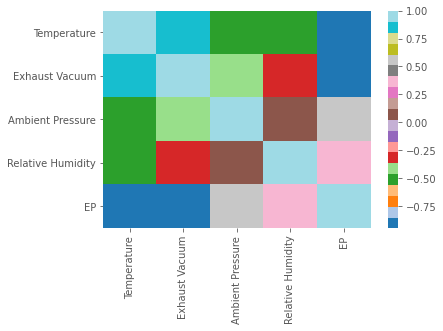

In [6]:
print(df.corr())
# for importing seaborn
import seaborn as sns
sns.heatmap(df.corr(),cmap="tab20")

According to the matrix, Temperature and Exhaust Vacuum have very strong negative correlation with EP, which absolute value higher than 0.8. The strong correlation might indicate that these two variables are more “predictive”. Ambient Pressure has moderate positive correlation with EP, which means it is "somewhat predictive". Relative Humidity has a weak positive correlation with EP as the correlation coefficient is less than 0.4. It means the change of relative humidity does not affect too much on the EP.

## 3. Regression Model Construction & Evaluation
Based on the degree of "predictive", the final three explanatory variables candidates are Temperature, Exhaust Vacuum and Ambient Pressure. But here is another problem that the correlation coefficient is very high between Temperature and Exhaust Vacuum, which is over 0.8. In this case, they cannot be considered as truly independent. The strong correlation between two variables may make it hard for interpretation of model and creates overfitting problem. For seeing if the multicollinearity of the two variables will affect the prediction, three different linear regression models will be created:
- 1. Involve Temperature, Exhaust Vacuum and Ambient Pressure as explanatory variables.
- 2. Involve Temperature and Ambient Pressure as explanatory variables, kicking out Exhaust Vacuum.
- 3. Involve Exhaust Vacuum and Ambient Pressure as explanatory variables, kicking out Temperature.

Split the data set into training set and test set. The training set will be divided into 10 folds for K-fold cross-validation based on generalized experimentation suggestion. Each cross-validation score will be stored and calculated the mean value for model evaluation. <br>
<br>
#### Model 1
The first model will include three explanatory variables. (Temperature, Exhaust Vacuum and Ambient Pressure).
Firstly, split the dataset into explanatory variables group X and response variable y. Then apply train_test_split() function to split X and y into training and testing sets. The set held out for testing is 30% of the whole data set. 

In [7]:
# import the train_test_split function
from sklearn.model_selection import train_test_split
# import the LinearRegression function
from sklearn.linear_model import LinearRegression
# import the cross_val_score function
from sklearn.model_selection import cross_val_score

# define the involved predictors X
X=df.iloc[:,[0,1,2]]
# define the dependent variable y
y=df[['EP']]
# split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
# sanity check
X_train.head(), y_train.head()

(      Temperature  Exhaust Vacuum  Ambient Pressure
 2311        27.71           70.32           1008.63
 435          9.43           37.14           1013.03
 1509        25.21           65.34           1013.94
 5297        31.68           74.16           1011.30
 1361         6.79           39.37           1019.79,
           EP
 2311  432.59
 435   473.57
 1509  446.68
 5297  434.61
 1361  487.30)

Following the concept of cross-validation, the training set will be divided into 10 folds for fitting the model. Each fold will have a chance to be the validation fold to assess the accuracy. Total 10 times. Then the final accuracy will be calculated as the mean value of each validation accuracy.

In [8]:
# setting a linearregression model
model_1 = LinearRegression()
# fit the model with 10-fold cross validation and test the accruracy
scores = cross_val_score(model_1, X_train, y_train, cv=10)
# print out the accuracy metrics derived from the K-fold cross validation process
print (scores)

[0.91876392 0.91790165 0.9167887  0.9097377  0.92304696 0.91608455
 0.92070222 0.92361327 0.92073041 0.92063853]


In [9]:
import numpy as np
# calculate the average accuracy across all 10 folds
print("The first model has "+ str(round(scores.mean(),2))+" accuracy with a standard deviation of "+str(round(scores.std(),2)))

The first model has 0.92 accuracy with a standard deviation of 0.0


#### Model 2
The second model will include two explanatory variables. (Temperature and Ambient Pressure). The procedure will be the same as the first model.

In [10]:
# extract 2 variables from X_train for new model creating 
X_train_2 = X_train[['Temperature', 'Ambient Pressure']].copy()

# setting a linearregression model_2
model_2 = LinearRegression()
# fit the model with 10-fold cross validation and test the accruracy
scores_2 = cross_val_score(model_2, X_train_2, y_train, cv=10)

# print out the accuracy metrics derived from the K-fold cross validation process
print (scores_2)

[0.90197736 0.90227738 0.89688073 0.89232048 0.90478513 0.89518148
 0.90480545 0.90862713 0.90325756 0.90292764]


In [11]:
# calculate the average accuracy across all 10 folds
print("The second model has "+ str(round(scores_2.mean(),2))+" accuracy with a standard deviation of "+str(round(scores_2.std(),2)))

The second model has 0.9 accuracy with a standard deviation of 0.0


#### Model 3
The third model will include two explanatory variables. (Exhaust Vacuum and Ambient Pressure). The procedure will be the same as the first and the second model.

In [12]:
# extract 2 variables from X_train for new model creating 
X_train_3 = X_train[['Exhaust Vacuum','Ambient Pressure']].copy()

# setting a linearregression model_3
model_3 = LinearRegression()
# fit the model with 10-fold cross validation and test the accruracy
scores_3 = cross_val_score(model_3, X_train_3, y_train, cv=10)

# print out the accuracy metrics derived from the K-fold cross validation process
print (scores_3)

[0.78894064 0.77939235 0.78126791 0.792733   0.80642603 0.7886677
 0.78601193 0.78843211 0.77601134 0.78526953]


In [13]:
# calculate the average accuracy across all 10 folds
print("The third model has "+ str(round(scores_3.mean(),2))+" accuracy with a standard deviation of "+str(round(scores_3.std(),2)))

The third model has 0.79 accuracy with a standard deviation of 0.01


As the accuracy results shows, the first and the second models both reached a 0.9 accuracy rate, which is obviously higher than the third model. The first model is slightly higher than the second model with one more variable Exhaust Vacuum included. However, the second model, without Exhaust Vacuum, has already reached a relatively high accuracy rate. It means the Exhaust Vacuum variable does not contribute too much on the prediction. Therefore, the most straight-forward method is to remove Exhaust Vacuum to avoid the potential multicollinearity problem, while the model still can keep a high cross validated accuracy. All in all, the second model is preferable.

## 4. Conclusions
Applying Cross-validation, linear regression models can be created with different explanatory variables for predicting the net hourly electrical energy output (EP). With two variables, Temperature and Ambient Pressure, included, the model accuracy can reach 0.9.

### Reference
https://towardsdatascience.com/multi-collinearity-in-regression-fe7a2c1467ea<br>
https://towardsdatascience.com/finding-the-right-model-parameters-3670a1c086b3<br>
https://scikit-learn.org/stable/modules/cross_validation.html<br>
